In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
from config import nyt_key

### Retrieving Data From NYT's API
* The below function requests all keywords and their publication dates for every article published between March - July for any given year
* It returns a series of unique keywords and their total counts for any given year

In [2]:
def pull_keywords(year):    
    months = ["3","4","5","6","7"]
    keywords = []
    keyword_dates = []
    for month in months:
        base_url = f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={nyt_key}"
        response = requests.get(base_url).json()["response"]["docs"]
        for i in response:
            for j in i["keywords"]:
                keywords.append(j["value"])
                keyword_dates.append(i["pub_date"])
    df = pd.DataFrame({"publication_date":keyword_dates,"keywords":keywords})
    series = df["keywords"].value_counts()
    return series

In [6]:
series_2008 = pull_keywords(2008)
series_2012 = pull_keywords(2012)
series_2016 = pull_keywords(2016)
series_2020 = pull_keywords(2020)
series_2020.head(10)

Coronavirus (2019-nCoV)                  13860
United States Politics and Government     4050
Trump, Donald J                           3788
Presidential Election of 2020             3072
Quarantines                               2936
Primaries and Caucuses                    1658
United States                             1580
Black People                              1565
Coronavirus Reopenings                    1520
New York City                             1512
Name: keywords, dtype: int64

### Most Discussed Topics
#### Clear Winner
* Covid-19 is dominating today's headlines more than any other subject before it.
* The upcoming presidential election has taken a backseat to the virus and a few other political topics in this unusual election year.

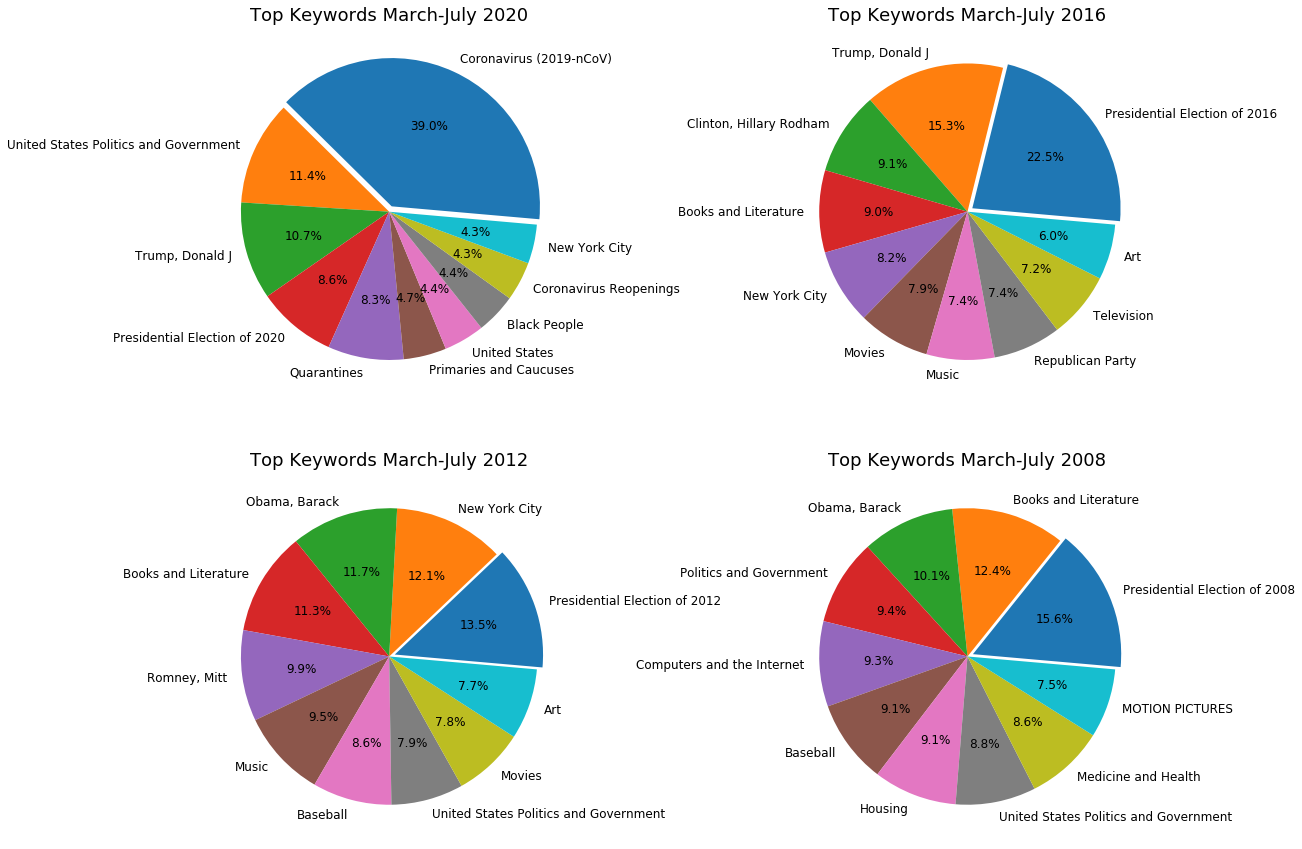

In [43]:
# Find top keywords for each year
top_keywords_2020 = series_2020.sort_values(ascending=False)[0:10]
top_keywords_2016 = series_2016.sort_values(ascending=False)[0:10]
top_keywords_2012 = series_2012.sort_values(ascending=False)[0:10]
top_keywords_2008 = series_2008.sort_values(ascending=False)[0:10]

# Plotting
fig, (ax1, ax2) = plt.subplots(2,2,figsize=(19,15))
explode = (.04,0,0,0,0,0,0,0,0,0) 
ax1[0].pie(top_keywords_2020,explode=explode,labels=top_keywords_2020.index,autopct="%1.1f%%",startangle=-5,textprops={'fontsize': 12})
ax1[1].pie(top_keywords_2016,explode=explode,labels=top_keywords_2016.index,autopct="%1.1f%%",startangle=-5,textprops={'fontsize': 12})
ax2[0].pie(top_keywords_2012,explode=explode,labels=top_keywords_2012.index,autopct="%1.1f%%",startangle=-5,textprops={'fontsize': 12})
ax2[1].pie(top_keywords_2008,explode=explode,labels=top_keywords_2008.index,autopct="%1.1f%%",startangle=-5,textprops={'fontsize': 12})
ax1[0].set_title("Top Keywords March-July 2020",fontsize=18)
ax1[1].set_title("Top Keywords March-July 2016",fontsize=18)
ax2[0].set_title("Top Keywords March-July 2012",fontsize=18)
ax2[1].set_title("Top Keywords March-July 2008",fontsize=18)
plt.savefig("Images/pies.png")
plt.show()

### Building The DataFrame and Analysis

In [4]:
# Create DataFrame from series'
df = pd.concat([series_2020,series_2016,series_2012,series_2008],axis=1)
newcolumns=df.columns.values
newcolumns[0] = '2020'
newcolumns[1] = '2016'
newcolumns[2] = '2012'
newcolumns[3] = '2008'
# df.to_csv("Data/keywords_raw.csv")

NameError: name 'series_2020' is not defined

In [5]:
df = pd.read_csv("Data/keywords_raw.csv").fillna(0)
df = df.rename(columns={"Unnamed: 0":"Keywords"})
df.head()

,Keywords,2020,2016,2012,2008
0,Coronavirus (2019-nCoV),13860.0,0.0,0.0,0.0
1,United States Politics and Government,4050.0,1079.0,1452.0,1270.0
2,"Trump, Donald J",3788.0,3050.0,26.0,8.0
3,Presidential Election of 2020,3072.0,3.0,0.0,0.0
4,Quarantines,2936.0,2.0,0.0,0.0


In [6]:
df['2008-16 Average']=df[['2016', '2012', '2008']].mean(axis=1)
df.head()

,Keywords,2020,2016,2012,2008,2008-16 Average
0,Coronavirus (2019-nCoV),13860.0,0.0,0.0,0.0,0.000000
1,United States Politics and Government,4050.0,1079.0,1452.0,1270.0,1267.000000
2,"Trump, Donald J",3788.0,3050.0,26.0,8.0,1028.000000
3,Presidential Election of 2020,3072.0,3.0,0.0,0.0,1.000000
4,Quarantines,2936.0,2.0,0.0,0.0,0.666667


In [7]:
df=df.loc[(df['2008']>0) & (df['2012']>0) & (df['2016']>0)]
df['Keyword Ocurrence Change']=df["2020"]/df["2008-16 Average"]
df = df.sort_values('Keyword Ocurrence Change', ascending=False)
df.head()

,Keywords,2020,2016,2012,2008,2008-16 Average,Keyword Ocurrence Change
160,"Fauci, Anthony S",185.0,3.0,1.0,1.0,1.666667,111.000000
13,Epidemics,1316.0,30.0,29.0,13.0,24.000000,54.833333
156,Videophones and Videoconferencing,188.0,11.0,3.0,1.0,5.000000,37.600000
19,"Biden, Joseph R Jr",1128.0,33.0,61.0,9.0,34.333333,32.854369
16,Shutdowns (Institutional),1265.0,49.0,51.0,34.0,44.666667,28.320896


In [12]:
def percent_of_total(keyword):
    points = []
    row = df.loc[df["Keywords"]==f"{keyword}",["2008", "2012", "2016","2020"]]
    total = row.sum(axis=1)
    for i in row:
        row[i] = round(row[i]/total*100,2)
        points.append(float(row[i]))
    x_value = np.arange(4)
    labels = ["2008", "2012", "2016","2020"]
    return points, x_value, labels

def plot_three_keywords(keyword_1,keyword_2,keyword_3):
    # Creating percent of total data for plotting
    points_1, x_values, labels = percent_of_total(f"{keyword_1}")
    points_2, x_values, labels = percent_of_total(f"{keyword_2}")
    points_3, x_values, labels = percent_of_total(f"{keyword_3}")

    # Plotting
    plt.figure(figsize=(15,7))
    width = 0.2
    plt.bar(x_values, points_1 , width, label=f"{keyword_1}")
    plt.bar(x_values + width, points_2, width, label=f"{keyword_2}")
    plt.bar(x_values + (width*2), points_3, width, label=f"{keyword_3}")

    # Chart design
    plt.ylabel("Percent of Total Keyword Mentions (2008-2020)",size=12)
    plt.title(f"Healthcare - At The Forefront Of American Minds",size=14)
    plt.xticks(x_values + width, ("2008", "2012", "2016","2020"),size=12)
    plt.yticks(size=12)
    plt.legend(loc='best')
    plt.savefig("Images/economy_2.png")
    plt.show()
    
def plot_two_keywords(keyword_1,keyword_2):
    # Creating percent of total data for plotting
    points_1, x_values, labels = percent_of_total(f"{keyword_1}")
    points_2, x_values, labels = percent_of_total(f"{keyword_2}")

    # Plotting
    plt.figure(figsize=(15,7))
    width = 0.2
    plt.bar(x_values, points_1 , width, label=f"{keyword_1}")
    plt.bar(x_values + width, points_2, width, label=f"{keyword_2}")

    # Chart design
    plt.ylabel("%",size=12)
    plt.title(f"Percent of Total Keyword Mentions (March-July)",size=14)
    plt.xticks(x_values+width/2, ("2008", "2012", "2016","2020"),size=12)
    plt.yticks(size=12)
    plt.legend(loc='best')
    plt.show()
    
def plot_elections_vs_covid():
    # Import data from csv
    df_2008 = pd.read_csv("Data/2008_dates_and_keyword.csv")
    df_2012 = pd.read_csv("Data/2012_dates_and_keyword.csv")
    df_2016 = pd.read_csv("Data/2016_dates_and_keyword.csv")
    df_2020 = pd.read_csv("Data/2020_dates_and_keyword.csv")
    df_raw = pd.concat([df_2020,df_2016,df_2012,df_2008])
    df_raw = df_raw.drop("Unnamed: 0",axis=1)

    # Get keyword counts
    keyword_count = df_raw.keywords.value_counts()

    # Find invidual counts for desired keywords
    counts_2008 = keyword_count.loc[keyword_count.index=="Presidential Election of 2008"]
    counts_2012 = keyword_count.loc[keyword_count.index=="Presidential Election of 2012"]
    counts_2016 = keyword_count.loc[keyword_count.index=="Presidential Election of 2016"]
    counts_2020 = keyword_count.loc[keyword_count.index=="Presidential Election of 2020"]
    coronavirus = keyword_count.loc[keyword_count.index=="Coronavirus (2019-nCoV)"]

    # Plotting
    plt.figure(figsize=(15,7))
    plt.xticks([1,2,3,4,5],labels=["Presidential Election of 2008","Presidential Election of 2012","Presidential Election of 2016","Presidential Election of 2020","Coronavirus (2019-nCoV)"],size=10)
    plt.bar(5,coronavirus,label="Coronavirus (2019-nCoV)")
    plt.bar(4,counts_2020)
    plt.bar(3,counts_2016)
    plt.bar(2,counts_2012)
    plt.bar(1,counts_2008)
    plt.title("Total Count of Keyword Mentions (March-July)",size=14)
    plt.ylabel("Number of Mentions",size=12)
    plt.show()

## Plotting Trends Of Historically Important Voter Issues

## Economy

#### Spotlight on Small buisness
- Small buisnesses are on the front lines of this pandemic's harsh economic evironment and may be facing what could be a longer road to recovery when compared to larger, more established buisnesses. 

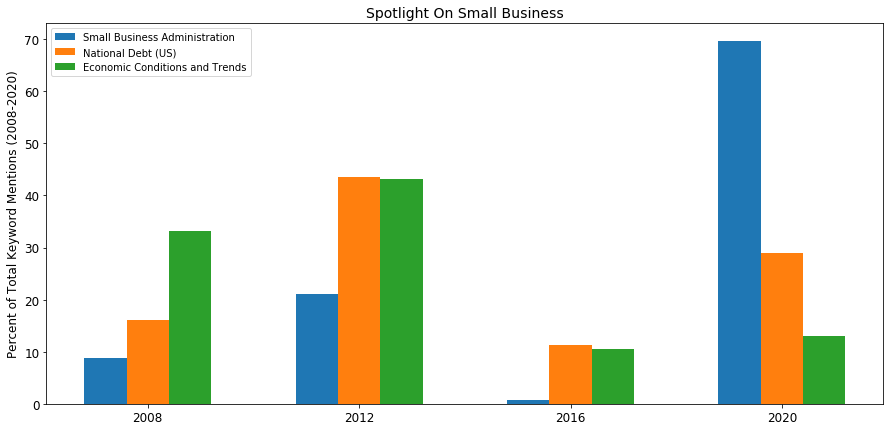

In [9]:
plot_three_keywords("Small Business Administration","National Debt (US)","Economic Conditions and Trends")

#### Indistries Built For a Pandemic
- Some industries are seeing exponential growth in media attention which may translate to more profits as people around the world are inquiring about their products and services.

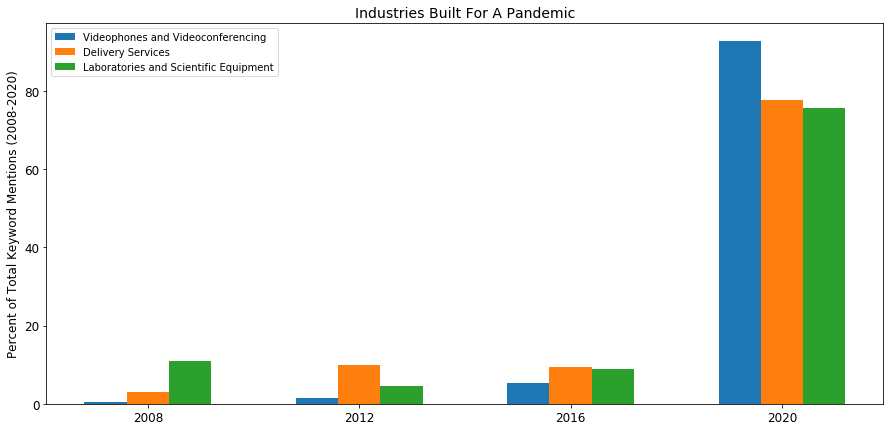

In [11]:
plot_three_keywords("Videophones and Videoconferencing","Delivery Services","Laboratories and Scientific Equipment")

### Healthcare

#### At The Forefront Of American Minds
* Hospitals, nurses and emergency responders are getting enourmous attention as the pandemic continues to take lives around the world.

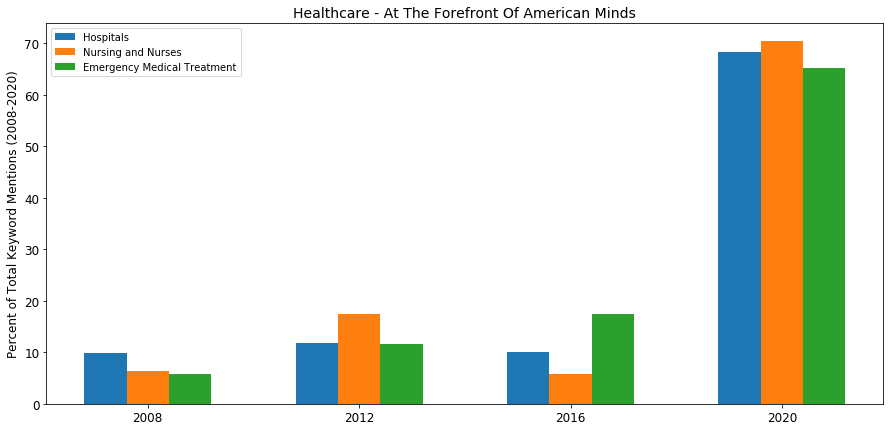

In [13]:
plot_three_keywords("Hospitals","Nursing and Nurses","Emergency Medical Treatment")

### Education

#### Trending sideways
* No real movement in keyword mentions related to education signals consumer attention is elsewhere.
* Schools being forced to shutdown did not play a significant role in demand for media coverage of topics related to education.

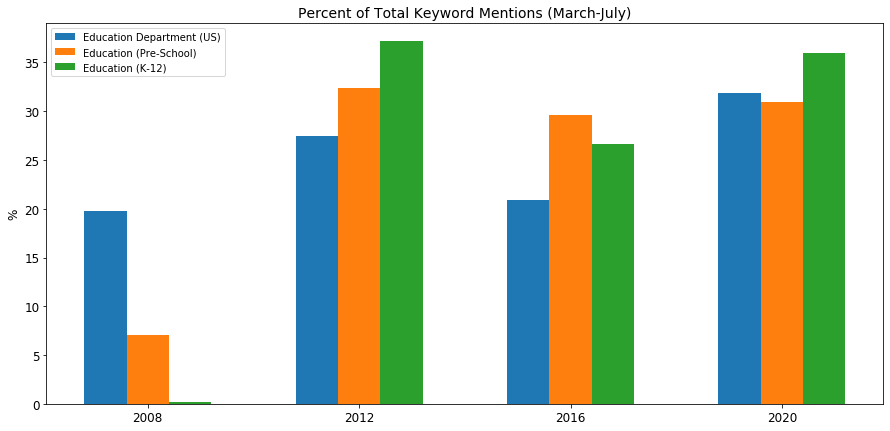

In [23]:
plot_three_keywords("Education Department (US)","Education (Pre-School)","Education (K-12)")

### Politics

#### Parties Competing For The Spotlight
* Media's focus on the Democratic Party is gaining momentum as we approach the 2020 election.
* The Republican Party is seeing less media coverage in 2020 when compared to previous election years.

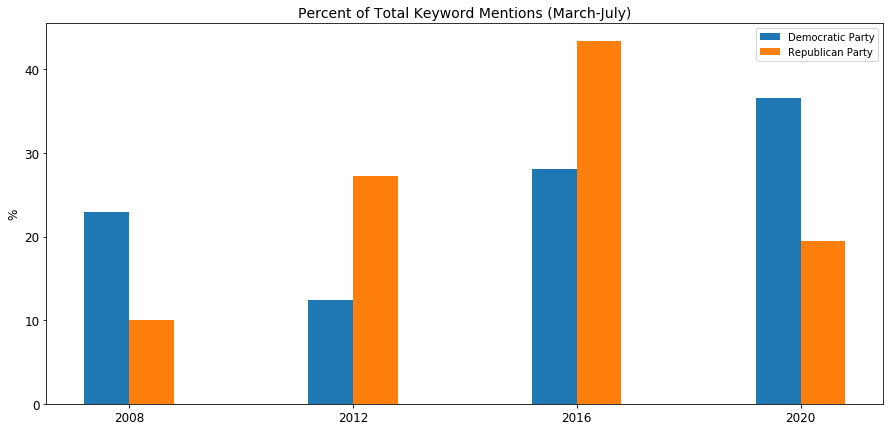

In [24]:
plot_two_keywords("Democratic Party","Republican Party")

#### Unprecedented Information Demand For Covid-19
* With Covid-19 dominating healines, election coverage may be diminished in favor of information about the pandemic.

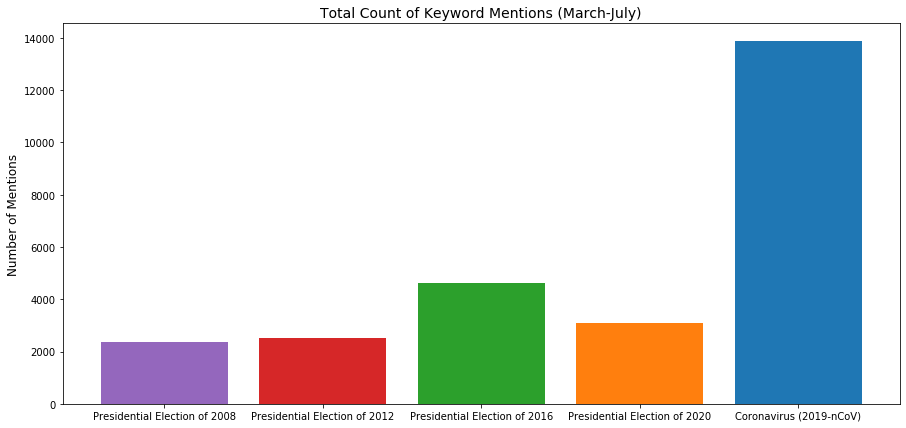

In [25]:
plot_elections_vs_covid()

### Government

#### Elevated Interest in US Politics and Government
- Today's Americans are more interested in US Politics and Goverment as the pandemic adds to political and ecomonic uncertainty.

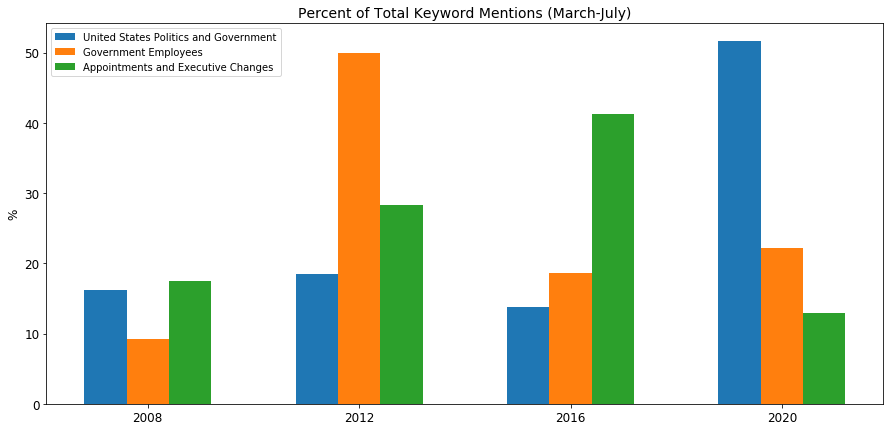

In [26]:
plot_three_keywords("United States Politics and Government","Government Employees","Appointments and Executive Changes")

#### Governors In The Spotlight
* With Governors leading their state's Covid-19 response, information about them has become highly sought after.
* This trend is also true for Presidents and Mayors though not as strongly skewed.

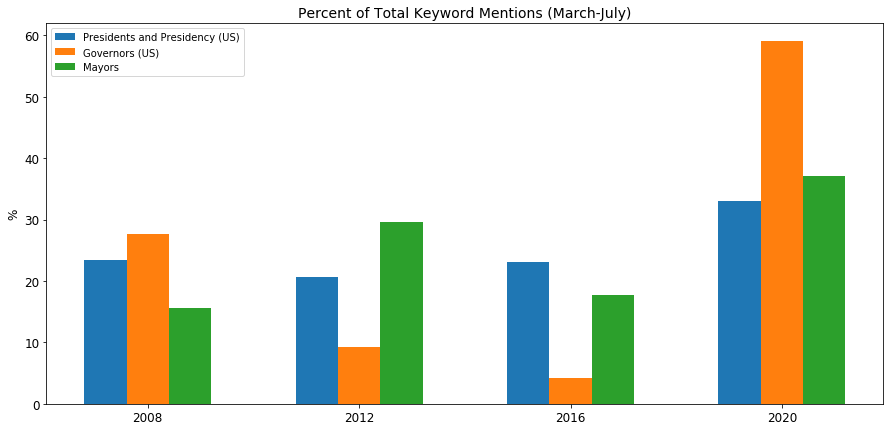

In [27]:
plot_three_keywords("Presidents and Presidency (US)","Governors (US)","Mayors")

### Taxes

#### Taking A BackSeat To Other Core Issues
- Taxes are being talked about less in 2020 when compared to previous election years.

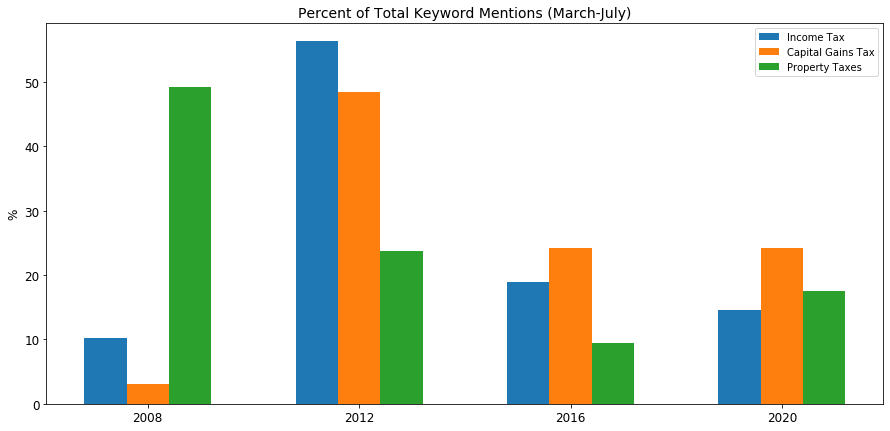

In [28]:
plot_three_keywords("Income Tax","Capital Gains Tax","Property Taxes")

### Gun Policy

#### Losing Popularity
* Information related to Gun Policy is becoming less sought after when compared to previous election years. 

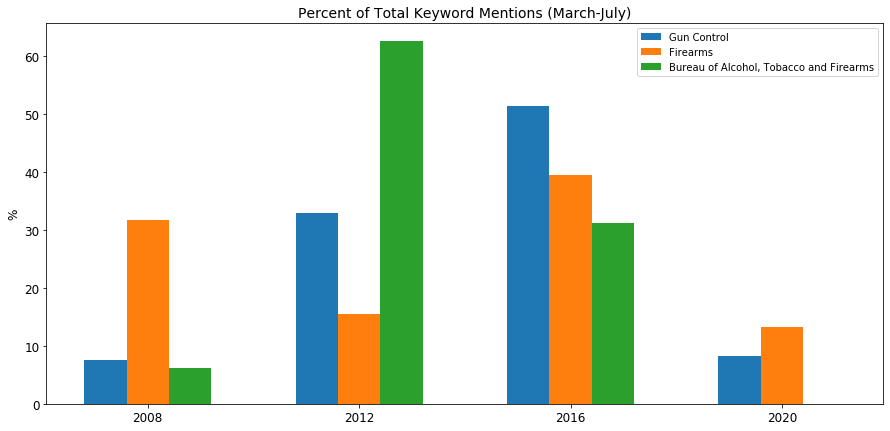

In [29]:
plot_three_keywords("Gun Control","Firearms","Bureau of Alcohol, Tobacco and Firearms")

### Terrorism

#### Focused on Higher Priority Issues
* American's are showing less interest in Terrorism as Covid-19 dominates current events.

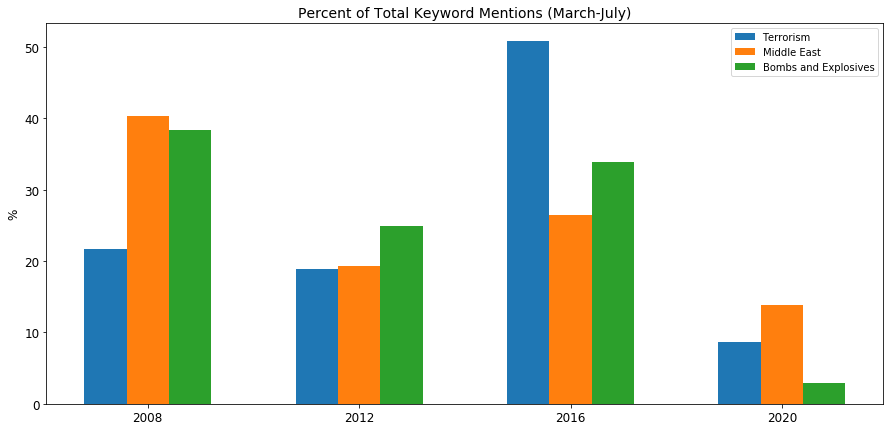

In [30]:
plot_three_keywords("Terrorism","Middle East","Bombs and Explosives")

### Immigration

#### Increase In Customs and Border Protection Interest
- Worldwide lockdowns and travel bans have increased demand for information related to Customs and Border Protection. 

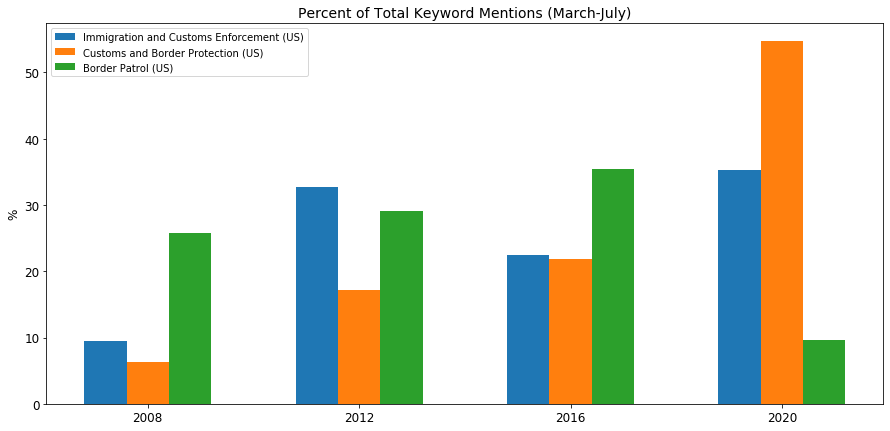

In [31]:
plot_three_keywords("Immigration and Customs Enforcement (US)","Customs and Border Protection (US)","Border Patrol (US)")

### Environment

#### Getting Outdoors
- When compared across all previous election years, demand for environmental information displays a sideways to negative trend.
- However, information related to Camping and Wilderness has seen a spike in 2020 when compared YOY. 

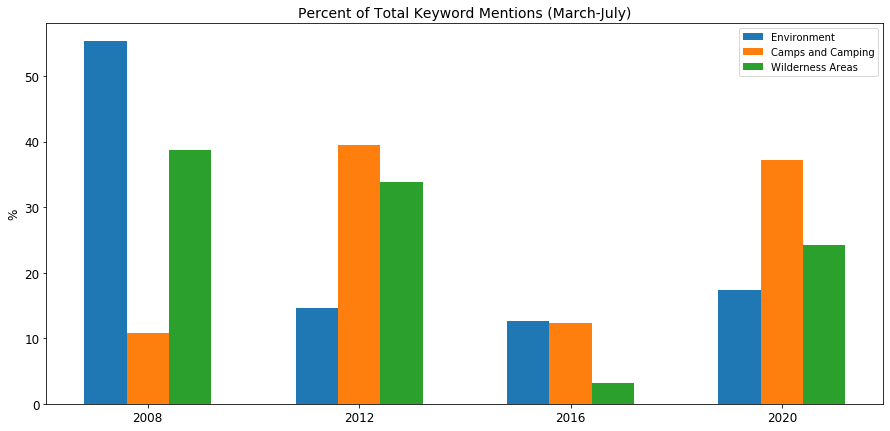

In [32]:
plot_three_keywords("Environment","Camps and Camping","Wilderness Areas")